# Tour of the EvCxR Jupyter Kernel
For those not already familiar with Jupyter notebook, it lets you write code into "cells" like the box below. Cells can alternatively contain markdown, like this text here. Each code cell is compiled and executed separately, but variables, defined functions etc persist between cells.

## Printing to outputs and evaluating expressions
Lets print something to stdout and stderr then return a final expression to see how that's presented. Note that stdout and stderr are separate streams, so may not appear in the same order is their respective print statements.

In [2]:
println!("Hello world");
eprintln!("Hello error");
format!("Hello {}", "world")

Hello error


Hello world


"Hello world"

## Assigning and making use of variables
We define a variable `message`, then in the subsequent cell, modify the string and finally print it out. We could also do all this in the one cell if we wanted.

In [3]:
let mut message = "Hello ".to_owned();

In [4]:
message.push_str("world!");

In [5]:
message

"Hello world!"

## Defining and redefining functions
Next we'll define a function

In [6]:
pub fn fib(x: i32) -> i32 {
    if x <= 2 {0} else {fib(x - 2) + fib(x - 1)}
}

In [7]:
(1..13).map(fib).collect::<Vec<i32>>()

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Hmm, that doesn't look right. Lets redefine the function. In practice, we'd go back and edit the function above and reevaluate it, but here, lets redefine it in a separate cell.

In [8]:
pub fn fib(x: i32) -> i32 {
    if x <= 2 {2} else {fib(x - 2) + fib(x - 1)}
}

In [9]:
let values = (1..13).map(fib).collect::<Vec<i32>>();
values

[2, 2, 4, 6, 10, 16, 26, 42, 68, 110, 178, 288]

## Spawning a separate thread and communicating with it
We can spawn a thread to do stuff in the background, then continue executing code in other cells.

In [10]:
use std::sync::{Mutex, Arc};
let counter = Arc::new(Mutex::new(0i32));
std::thread::spawn({
    let counter = Arc::clone(&counter);
    move || {
        for i in 1..300 {
            *counter.lock().unwrap() += 1;
            std::thread::sleep(std::time::Duration::from_millis(100));
        }
}});

In [11]:
*counter.lock().unwrap()

17

In [12]:
*counter.lock().unwrap()

29

## Loading external crates
We can load external crates. This one takes a while to compile, but once it's compiled, subsequent cells shouldn't need to recompile it, so it should be much quicker.

In [14]:
:dep base64 = "0.10.1"
base64::encode(&vec![1, 2, 3, 4])

"AQIDBA=="

## Customizing how types are displayed
We can also customize how our types are displayed, including presenting them as HTML. Here's an example where we define a custom display function for a type `Matrix`.

In [2]:
use std::fmt::Debug;
pub struct Matrix<T> {pub values: Vec<T>, pub row_size: usize}
impl<T: Debug> Matrix<T> {
    pub fn evcxr_display(&self) {
        let mut html = String::new();
        html.push_str("<table>");
        for r in 0..(self.values.len() / self.row_size) {
            html.push_str("<tr>");
            for c in 0..self.row_size {
                html.push_str("<td>");
                html.push_str(&format!("{:?}", self.values[r * self.row_size + c]));
                html.push_str("</td>");
            }
            html.push_str("</tr>");            
        }
        html.push_str("</table>");
        println!("EVCXR_BEGIN_CONTENT text/html\n{}\nEVCXR_END_CONTENT", html);
    }
}

In [3]:
let m = Matrix {values: vec![1,2,3,4,5,6,7,8,9], row_size: 3};
m

1,2,3
4,5,6
7,8,9


We can also return images, we just need to base64 encode them. First, we set up code for displaying RGB and grayscale images.

In [4]:
extern crate image;
extern crate base64;
pub trait EvcxrResult {fn evcxr_display(&self);}
impl EvcxrResult for image::RgbImage {
    fn evcxr_display(&self) {
        let mut buffer = Vec::new();
        image::png::PNGEncoder::new(&mut buffer).encode(&**self, self.width(), self.height(),
            image::ColorType::RGB(8)).unwrap();
        let img = base64::encode(&buffer);
        println!("EVCXR_BEGIN_CONTENT image/png\n{}\nEVCXR_END_CONTENT", img);        
    }
}
impl EvcxrResult for image::GrayImage {
    fn evcxr_display(&self) {
        let mut buffer = Vec::new();
        image::png::PNGEncoder::new(&mut buffer).encode(&**self, self.width(), self.height(),
            image::ColorType::Gray(8)).unwrap();
        let img = base64::encode(&buffer);
        println!("EVCXR_BEGIN_CONTENT image/png\n{}\nEVCXR_END_CONTENT", img);        
    }
}

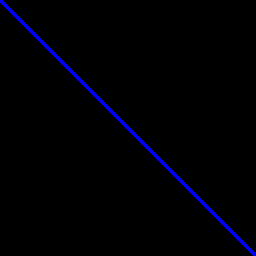

In [5]:
image::ImageBuffer::from_fn(256, 256, |x, y| {
    if (x as i32 - y as i32).abs() < 3 {
        image::Rgb([0, 0, 255])
    } else {
        image::Rgb([0, 0, 0])
    }
})

## Display of compilation errors
Here's how compilation errors are presented. Here we forgot an & and passed a String instead of an &str.

In [17]:
let mut s = String::new();
s.push_str(format!("foo {}", 42));

Error: mismatched types

## Seeing what variables have been defined
We can print a table of defined variables and their types with the :vars command.

In [19]:
:vars

Variable,Type
counter,std::sync::Arc<std::sync::Mutex<i32>>
message,String
m,user_code_13::Matrix<i32>
values,std::vec::Vec<i32>


Other built-in commands can be found via :help

In [3]:
:help

:vars             List bound variables and their types
:opt [level]      Toggle/set optimization level
:explain          Print explanation of last error
:clear            Clear all state, keeping compilation cache
:dep              Add dependency. e.g. :dep regex = "1.0"
:version          Print Evcxr version
:preserve_vars_on_panic [0|1]  Try to keep vars on panic

Mostly for development / debugging purposes:
:last_compile_dir Print the directory in which we last compiled
:timing           Toggle printing of how long evaluations take
:last_error_json  Print the last compilation error as JSON (for debugging)
:time_passes      Toggle printing of rustc pass times (requires nightly)
:internal_debug   Toggle various internal debugging code
